# Sequence Classifier RNN

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib.layers import fully_connected

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12    

In [ ]:
# computation graph construction
max_time = 28
d = 28
n_hid = 150
n_out = 10

eta = 0.001

X = tf.placeholder( tf.float32, [None, max_time, d] ) # shape is dictated by tensorflow: [N, seq_len, dim]
y = tf.placeholder( tf.int32, [None] )

basic_cell = tf.contrib.rnn.BasicRNNCell( num_units = n_hid )
outputs, states = tf.nn.dynamic_rnn( basic_cell, X, dtype = tf.float32 )

logits = fully_connected( states, n_out, activation_fn = None )
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits( labels = y, logits = logits )
loss = tf.reduce_mean( xentropy )
optimizer = tf.train.AdamOptimizer( learning_rate = eta )
training_op = optimizer.minimize( loss )
correct = tf.nn.in_top_k( logits, y, 1 )
accuracy = tf.reduce_mean( tf.cast( correct, tf.float32 ) )

init = tf.global_variables_initializer()

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, max_time, d))
y_test = mnist.test.labels

n_epochs = 100
batch_size = 150
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, max_time, d))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

In [ ]:
print(mnist.train.num_examples, mnist.test.num_examples)
X_batch, y_batch = mnist.train.next_batch(batch_size)
X_batch.shape
X_batch = X_batch.reshape( [-1, 28, 28] )
X_batch.shape

# Time-series Forecasting with RNN

In [2]:
t_min, t_max = 0, 30
resolution = 0.1
n_steps = 30
n_inputs = 1
n_neurons = 100
n_outputs = 1

def time_series(t):
    return t*np.sin(t)/3 + 2*np.sin(5*t)

def next_batch( batch_size, n_steps ):
    t0 = np.random.rand(batch_size, 1)*(t_max-t_min-n_steps*resolution)
    Ts = t0 + np.arange(0., n_steps+1)*resolution
    ys = time_series( Ts )
    return ys[:,:-1].reshape( -1, n_steps, 1 ), ys[:,1:].reshape( -1, n_steps, 1 )

t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

In [3]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

# cell = tf.contrib.rnn.BasicRNNCell( num_units = n_neurons, activation = tf.nn.relu)
cell = tf.contrib.rnn.OutputProjectionWrapper( tf.contrib.rnn.BasicRNNCell( num_units = n_neurons, activation = tf.nn.relu), output_size = n_outputs )
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)

learning_rate = 0.001

loss = tf.reduce_mean( tf.square(outputs - y) )
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)        

In [4]:
init = tf.global_variables_initializer()

n_iterations = 2000
batch_size = 7

with tf.Session() as sess:
    init.run()
    for it in range( n_iterations ):
        X_batch, y_batch = next_batch( batch_size, n_steps )
        sess.run( training_op, feed_dict = {X: X_batch, y: y_batch} )
        if it % 100 == 0:
            mse = loss.eval( feed_dict = {X: X_batch, y: y_batch} )
            print( it, "\tMSE:", mse )
    tf.train.Saver().save(sess, "./my_time_series_model")

0 	MSE: 11.932003
100 	MSE: 0.39737898
200 	MSE: 0.12631594
300 	MSE: 0.09194018
400 	MSE: 0.080602095
500 	MSE: 0.052615475
600 	MSE: 0.03255664
700 	MSE: 0.047224008
800 	MSE: 0.020967495
900 	MSE: 0.02454162
1000 	MSE: 0.03882543
1100 	MSE: 0.018764101
1200 	MSE: 0.044807762
1300 	MSE: 0.026764281
1400 	MSE: 0.018864298
1500 	MSE: 0.021589069
1600 	MSE: 0.029798256
1700 	MSE: 0.038090497
1800 	MSE: 0.027840462
1900 	MSE: 0.026688796


In [5]:
with tf.Session() as sess:                          # not shown in the book
    tf.train.Saver().restore(sess, "./my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


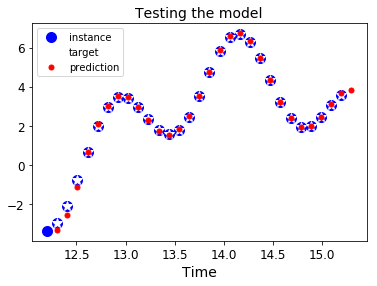

In [6]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Generating new series

In [7]:
with tf.Session() as sess:                        # not shown in the book
    tf.train.Saver().restore(sess, "./my_time_series_model") # not shown

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


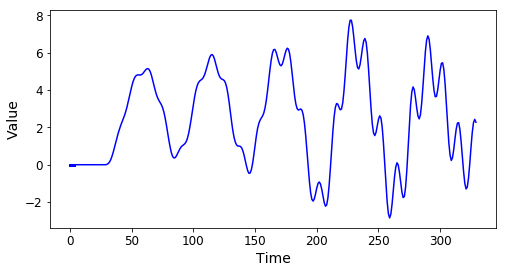

In [10]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()